In [27]:
# ball: m = 1 kg
# pole: L = 1 m
# cart: M = 4 kg


import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import max_norm



# TODO should move all this to a module (probably merge with the old cartpole module we were using)

g = 9.81  # m/s^2
L = 1.0  # length of the pole (m)
M = 4.0  # mass of the cart (kg)
m = 1  # mass of the ball at the end of the pole (kg)

rad = np.pi / 180
u_hist = []


#animation generation
def animate_pend(y):
    th = y[:,0]
    x1 = y[:,1]
    y1 = 0.0

    x2 = L * sin(th) + x1
    y2 = -L * cos(th) + y1

    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, aspect='equal', \
                     xlim=(-3, 3), ylim=(-3, 3))
    ax.grid()

    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text


    def animate(i):
        thisx = [x1[i], x2[i]]
        thisy = [y1, y2[i]]

        line.set_data(thisx, thisy)
        time_text.set_text(time_template % (i * dt))
        return line, time_text


    return animation.FuncAnimation(fig, animate, np.arange(1, len(y)), interval=40, blit=True, init_func=init)



# control input: u = F
# q is the state vector
def control(q):
    if (q[0] < 140 * rad) or (q[0] > 220 * rad):
        # swing up
        # energy error: Ee
        Ee = 0.5 * m * L * L * q[2] ** 2 - m * g * L * (1 + cos(q[0]))
        # energy control gain:
        k = 0.23
        # input acceleration: A (of cart)
        A = k * Ee * cos(q[0]) * q[2]
        # convert A to u (using EOM)
        delta = m * sin(q[0]) ** 2 + M
        u = A * delta - m * L * (q[2] ** 2) * sin(q[0]) - m * g * sin(q[2]) * cos(q[2])
    else:
        # balancing
        # LQR: K values from MATLAB
        k1 = 140.560
        k2 = -3.162
        k3 = 41.772
        k4 = -8.314
        u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
        
    return u


# state vector: q = transpose([theta, x, d(theta)/dt, dx/dt])
def derivs(q, t):
    dqdt = np.zeros_like(q)

    # control input
    u = control(q)

    delta = m * sin(q[0]) ** 2 + M

    dqdt[0] = q[2]
    dqdt[1] = q[3]

    dqdt[2] = - m * (q[2] ** 2) * sin(q[0]) * cos(q[0]) / delta \
              - (m + M) * g * sin(q[0]) / delta / L \
              - u * cos(q[0]) / delta / L

    dqdt[3] = m * L * (q[2] ** 2) * sin(q[0]) / delta \
              + m * L * g * sin(q[0]) * cos(q[0]) / delta / L \
              + u / delta

    return dqdt

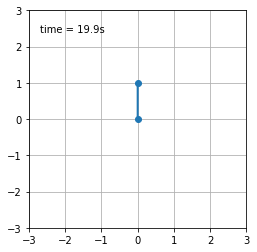

In [2]:
# time step
dt = 0.1
t = np.arange(0.0, 20, dt)

rad = np.pi / 180


num_trials = 1
num_states = 4
num_t = len(t)
y = np.zeros((num_t, num_states, num_trials))


for i in range(num_trials):
    # initial conditions
    theta = 0
    x = 0.0
    th_dot = 2*(i/num_trials) - 1  # an initial velocity, triggers the swing up control
    xdot = 0.0

    # initial state
    state = np.array([theta, x, th_dot, xdot])

    # integrate the ODE using scipy.integrate.
    u_hist = []
    y[:, :, i] = integrate.odeint(derivs, state, t)


u = np.zeros((num_t, num_trials))
for i in range(num_trials):
    for t in range(num_t):
        u[t,i] = control(y[t,:,i]) 

        
ani = animate_pend(y[:,:,0])
HTML(ani.to_html5_video())



In [116]:
# Create our LSTM network

look_back = 1

with tf.variable_scope('pi/pol/'):
    model = Sequential()
    model.add(LSTM(12, input_shape=(4,look_back)))
    #model.add(LSTM(4, input_shape =(12,look_back)))
    model.add(Dense(1))

    #model.add(Dense(2))
    

model.compile(loss='mean_squared_error', optimizer='adam')

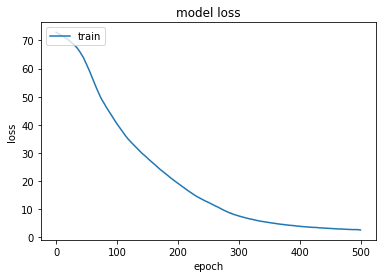

In [117]:
history = model.fit(y, u, epochs=500, verbose=0)
%matplotlib inline
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [10]:
# This is a closure that returns our NN controller
def make_controller(model):
    def nn_controller(q):
        if (q[0] < 140 * rad) or (q[0] > 220 * rad):
            return model.predict(q.reshape((1,4,1)))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = -3.162
            k3 = 41.772
            k4 = -8.314
            u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
            return u
        
    return nn_controller

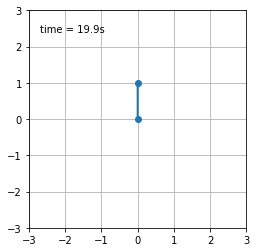

In [11]:
control = make_controller(model)

# initial conditions
theta = 0
x = 0
th_dot = .01 # an initial velocity, triggers the swing up control
xdot = 0.0
t = np.arange(0.0, 20, dt)


# initial state
state = np.array([theta, x, th_dot, xdot])

# integrate the ODE using scipy.integrate.
y_test = integrate.odeint(derivs, state, t)

ani = animate_pend(y_test)
HTML(ani.to_html5_video())

In [15]:
model.reset_states()

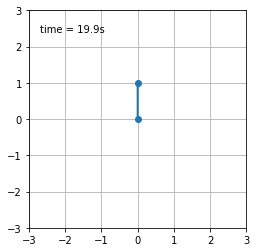

In [96]:
control = make_controller(model)

# initial conditions
theta = 0
x = 0
th_dot = .01 # an initial velocity, triggers the swing up control
xdot = 0.0
t_index = np.arange(0.0, 20, dt)


# initial state
state = np.array([theta, x, th_dot, xdot])

# integrate the ODE using scipy.integrate.
y_test = integrate.odeint(derivs, state, t_index)
u_test = np.zeros((y.shape[0],1))
for t in range(num_t):
        u_test[t] = control(y[t]) 

data = np.concatenate((y_test, u_test),axis=1)

names = [
    'theta',
    'x',
    'thetadot',
    'xdot',
    'u'
]

yf = pd.DataFrame(data = data, index = t_index, columns = names)


ani = animate_pend(y_test)
HTML(ani.to_html5_video())

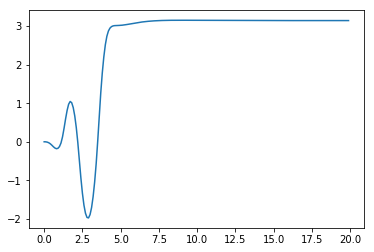

In [93]:
plt.plot(yf['state','theta'])
old_theta = yf['state','theta']


In [97]:
new_theta = yf['theta']

In [101]:
np.all(old_theta == new_theta)

True

,theta,x,thetadot,xdot
0.0,0.000000,0.000000,0.010000,0.000000
0.1,-0.001403,0.002405,-0.041635,0.051902
0.2,-0.009081,0.011275,-0.115813,0.130618
0.3,-0.025296,0.029642,-0.211497,0.242396
0.4,-0.051683,0.060752,-0.315478,0.383375
0.5,-0.087460,0.106420,-0.391026,0.526837
0.6,-0.127273,0.164773,-0.388753,0.630277
0.7,-0.161574,0.230072,-0.278472,0.662374
0.8,-0.179177,0.294299,-0.055581,0.606765
0.9,-0.169723,0.348576,0.257545,0.464209


In [ ]:
# messing with multiindexing 
# TODO probably move this to the misc folder, preferably as a more complete example than this one.

names = [
    ('state', 'theta'),
    ('state', 'x'),
    ('state', 'thetadot'),
    ('state', 'xdot'),
    ('control' ,'u')
]

yf = pd.DataFrame(data = data, index = t_index, columns=pd.MultiIndex.from_tuples(names))
